In [191]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior, beta_tuning_param_function,
                   load_posterior, simulator_hnn, get_dataset_psd, get_dataset_bandpower,
                   get_parameter_recovery, get_posterior_predictive_check, PriorBetaFiltered)
from viz import plot_spikes_raster
from hnn_core import calcium_model, simulate_dipole
from hnn_core.viz import NetworkPlotter
from hnn_core.check import _gid_to_type
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from neurodsp.spectral import compute_spectrum, trim_spectrum
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
import scipy


rng_seed = 123
rng = np.random.default_rng(rng_seed)

scale_factor = 60_000

# sns.set()
# sns.set_style("white")

device = 'cpu'

data_path = '/expanse/lustre/scratch/ntolley/temp_project/beta_tuning'

# with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
#     posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)

dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
gid_ranges = sim_metadata['gid_ranges']
gid_to_type = partial(_gid_to_type, gid_ranges=gid_ranges)
# extra_dict = posterior_metadata['extra_dict']
# window_samples = extra_dict['window_samples'] 
theta_extra = sim_metadata['theta_extra']

flow_idx = 3
dpl = np.load(f'{data_path}/sbi_sims/dpl_sbi_{flow_idx}.npy')
theta = np.load(f'{data_path}/sbi_sims/theta_sbi_{flow_idx}.npy')
spike_gids = np.load(f'{data_path}/sbi_sims/spike_gids_sbi_{flow_idx}.npy', allow_pickle=True)
spike_times = np.load(f'{data_path}/sbi_sims/spike_times_sbi_{flow_idx}.npy', allow_pickle=True)

fs = 1000 / dt


In [192]:
freqs, powers = compute_spectrum(dpl[:, mask], fs, method='welch', avg_type='median')
freqs, powers = trim_spectrum(freqs, powers, [0, 100])

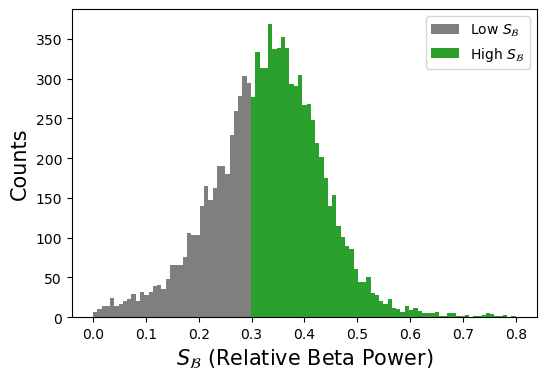

In [193]:
beta_mask = (freqs > 13) & (freqs < 30)
beta_power = powers[:, beta_mask].sum(axis=1)
beta_ratio = beta_power / powers.sum(axis=1)

ratio_sort = np.argsort(beta_ratio)[::-1]

thresh = 0.3
low_beta = beta_ratio < 0.3
high_beta = beta_ratio > 0.3


bins = np.linspace(0, 0.8, 100)

plt.figure(figsize=(6,4))
_ = plt.hist(beta_ratio[low_beta], bins=bins, color='C7', label='Low $S_\mathcal{B}$')
_ = plt.hist(beta_ratio[high_beta], bins=bins, color='C2', label='High $S_\mathcal{B}$')

plt.xlabel('$S_\mathcal{B}$ (Relative Beta Power)', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend()


In [201]:
sig = net.array

AttributeError: 'Network' object has no attribute 'array'

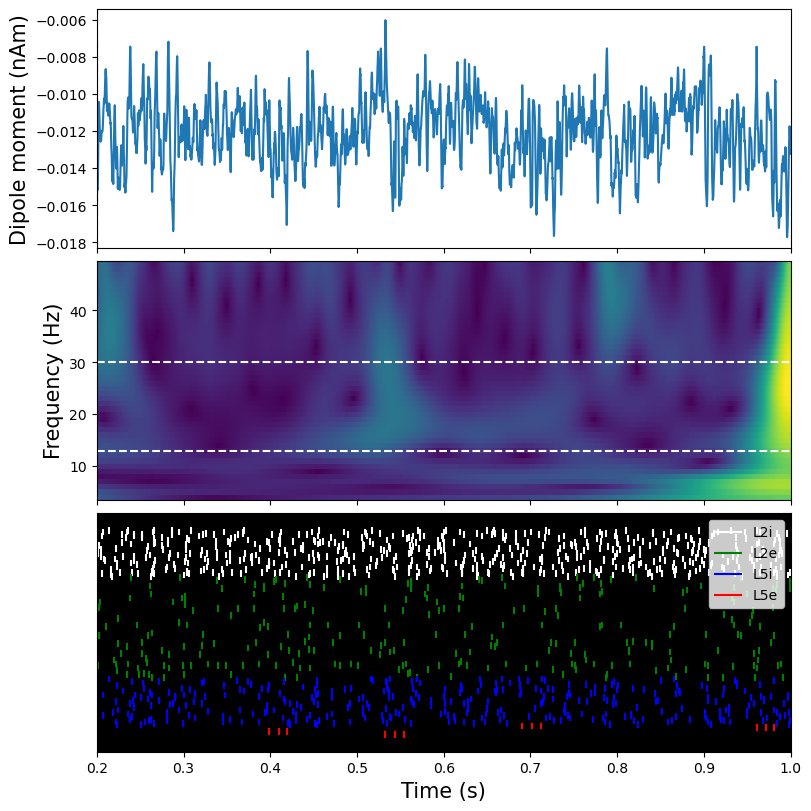

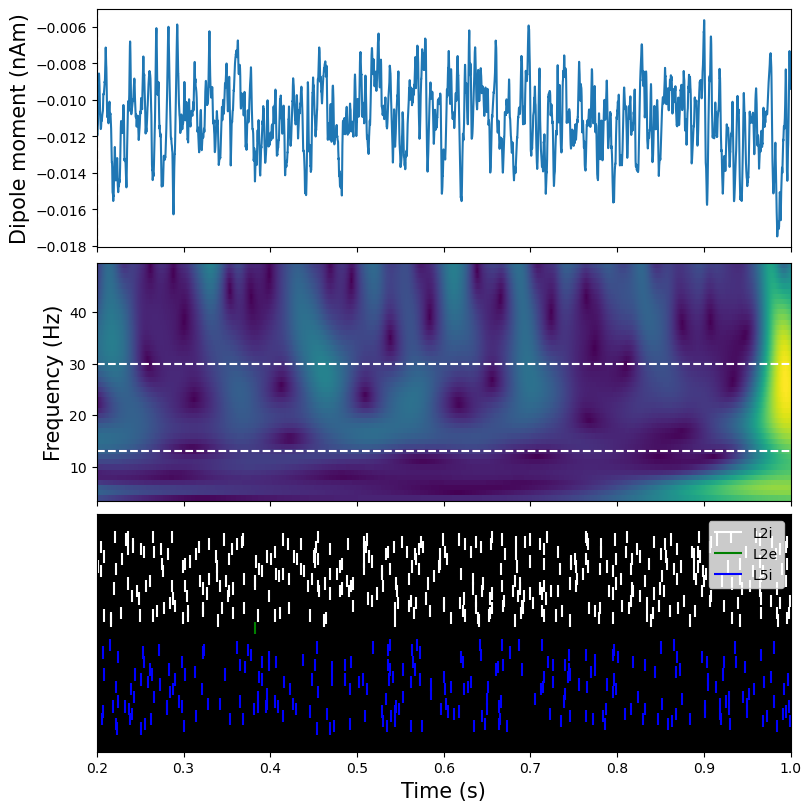

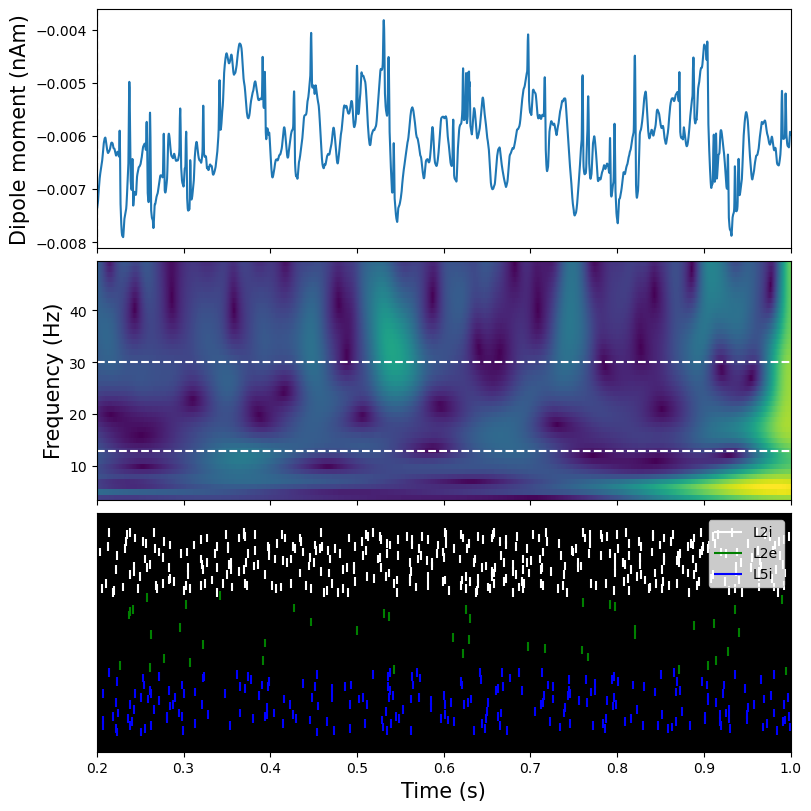

In [197]:
plot_freqs = np.arange(4,50,1)

x_tick_pos = np.linspace(0, times.size, 5)
x_ticks = np.round(np.linspace(times[0], times[-1], 5), 2)

times = np.linspace(0, 1, dpl.shape[1])
mask = times > 0.2 # burn in time
plot_times = times[mask]

for sim_idx in ratio_sort[6000:6003]:
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 8),constrained_layout=True)

    sig = dpl[sim_idx,:]
    
    spike_times_trial = np.array(spike_times[sim_idx]) / 1000
    spike_gids_trial = np.array(spike_gids[sim_idx])
    spike_types_trial = np.array(list(map(gid_to_type, spike_gids_trial)))
    
    axes[0].plot(plot_times, sig[mask])
    axes[0].set_ylabel('Dipole moment (nAm)', fontsize=15)
    axes[0].axvline(0.2, color='k', linestyle='--')
    
    mwt = compute_wavelet_transform(sig, fs, plot_freqs, n_cycles=4)
    plot_power = np.abs(mwt[:,mask])
    axes[1].pcolormesh(plot_times, plot_freqs, plot_power)
    axes[1].axhline(13, color='w', linestyle='--')
    axes[1].axhline(30, color='w', linestyle='--')
    axes[1].set_ylabel('Frequency (Hz)', fontsize=15)
    
    plot_spikes_raster(spike_times_trial, spike_gids_trial, spike_types_trial, gid_ranges, ax=axes[2])
    axes[2].set_ylabel('Cell ID', fontsize=15)
    axes[2].set_xlabel('Time (s)', fontsize=15)
    axes[2].set_xlim(0.2, 1)
    
    



In [189]:
high_beta_idx = ratio_sort[562]

net = calcium_model()
depths = np.linspace(-325, 2150, 100)
electrode_pos = [(4, 4, dep) for dep in depths]
net.add_electrode_array('shank1', electrode_pos)

high_beta_dict = {param_name: param_dict['rescale_function'](theta[high_beta_idx, idx], param_dict['bounds']) for 
                   idx, (param_name, param_dict) in enumerate(prior_dict.items())}
high_beta_dict['theta_extra'] = theta_extra
high_beta_dict['theta_extra']['sample_idx'] = 0
beta_tuning_param_function(net, high_beta_dict)

In [176]:
dpl = simulate_dipole(net, tstop=1000, dt=dt, record_vsec='all')

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.05 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Trial 1: 370.0 ms...
Trial 1: 380.0 ms...
Trial 1: 390.0 ms...
Trial 1: 400.0 ms...
Trial 1: 410.0 ms...
Trial 1: 420.0 ms...

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


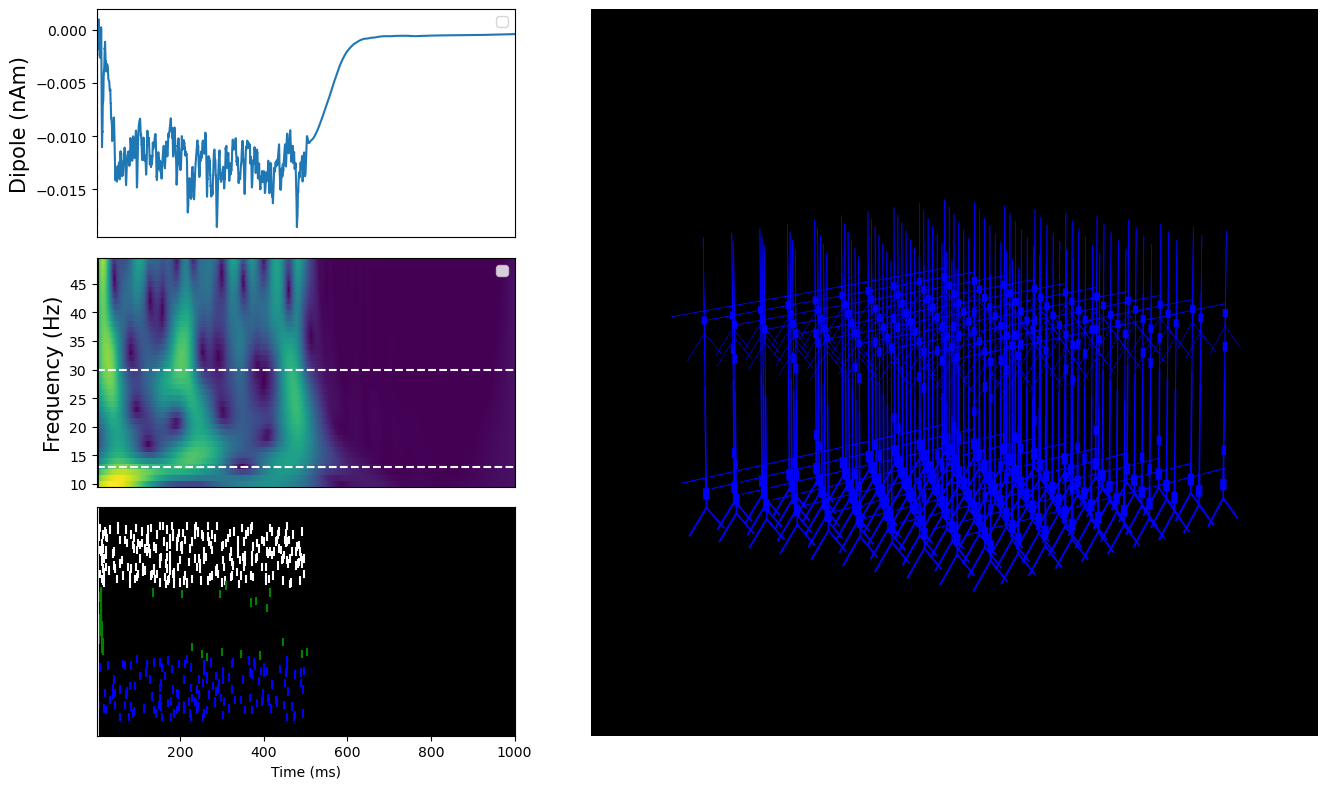

In [178]:
# Make plotting frame
times = net.cell_response.times
plot_mask = times > 0.2
times = times[plot_mask]

n_times = times.shape[0]
sig = dpl[0].data['agg'][plot_mask]

fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=1, colspan=1)
ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=1, colspan=1)
ax3 = plt.subplot2grid((3, 3), (2, 0), rowspan=1, colspan=1)
ax4 = plt.subplot2grid((3, 3), (0, 1), rowspan=3, colspan=2, projection='3d')
ax4.set_facecolor('k')

# Plot dipole
ax1.plot(times, sig)
ax1.set_ylabel('Dipole (nAm)', fontsize=15)
line1 = ax1.axvline(0.2, color='k', linestyle='--')
ax1.set_xlim(times[0], times[-1])
ax1.legend(loc='upper right')
ax1.set_xticks([])

# Plot spectrogram
plot_freqs = np.arange(10,50,1)
mwt = compute_wavelet_transform(sig, fs, plot_freqs, n_cycles=5)
plot_power = np.abs(mwt)
ax2.pcolormesh(times, plot_freqs, plot_power)
ax2.axhline(13, color='w', linestyle='--')
ax2.axhline(30, color='w', linestyle='--')
ax2.set_ylabel('Frequency (Hz)', fontsize=15)

line2 = ax2.axvline(0, linewidth=2, color='k')
ax2.set_xlim(times[0], times[-1])
ax2.legend(loc='upper right')
ax2.set_xticks([])

# Plot spikes
net.cell_response.plot_spikes_raster(ax=ax3, show=False)
line3 = ax3.axvline(0, linewidth=2, color='w')
ax3.get_legend().remove()
ax3.set_xlim(times[0], times[-1])

# Add network
net.set_cell_positions(inplane_distance=300.)
net_plot = NetworkPlotter(net, ax=ax4)

In [179]:
def update_frame(time_idx):
    line1.set_xdata([times[time_idx]])
    line2.set_xdata([times[time_idx]])
    line3.set_xdata([times[time_idx]])

    
    net_plot.time_idx = time_idx
    n_rotations = 0.4
    rot_pos = -100 + ((n_rotations / n_times) * time_idx * 360)
    net_plot.azim = rot_pos
    


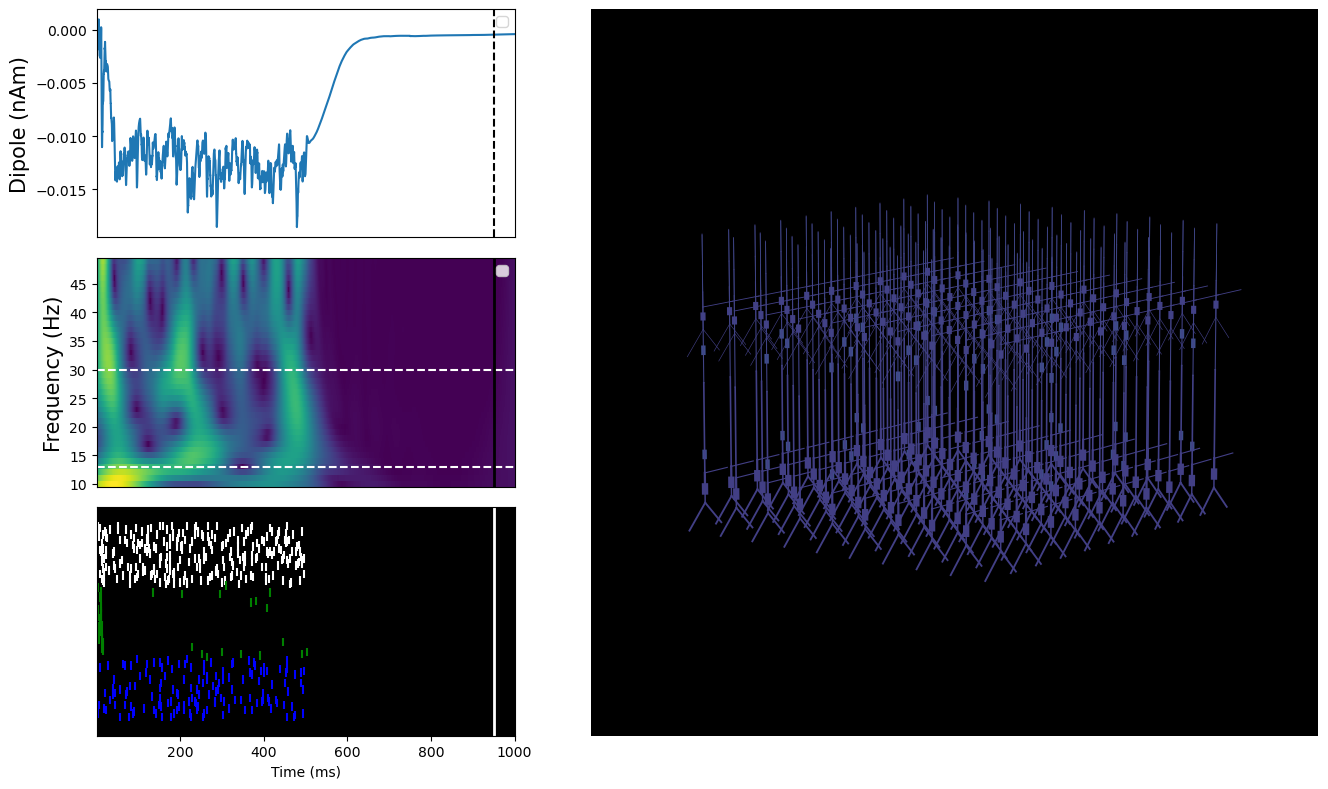

In [187]:
update_frame(19000)
fig

In [ ]:
frame_start = 0
frame_stop = len(times) - 1
decim = 10
interval = 30
fps = 30
dpi = 50
writer = 'pillow'

frames = np.arange(frame_start, frame_stop, decim)
ani = animation.FuncAnimation(
    fig, update_frame, frames, interval=interval)

writer = animation.writers[writer](fps=fps)
ani.save('mid_beta.gif', writer=writer, dpi=dpi)